#Mounting Google Drive


In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the libraries

In [2]:
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import optimizers, losses, activations, models
import pathlib
import shutil
from keras.models import Model

In [3]:
import cv2

# Get data:

In [4]:
def get_data():
    if 'Dataset' in os.listdir():
        print('Dataset already exists')
    else:
        # print('Downloading the data...')
        # !gdown --id 1WBhCaHNG0Uh20MNsV3l9kjVXqzFilBQL
        # print('Dataset downloaded!')
        # print('Copying Zip file to your Drive..')
        # !cp /content/split-VietnameseFoods-30.tar.gz 'drive/My Drive/VietnameseFoods-30'
        # print('Copying done!')
        print('Copying the data...')
        !cp /content/drive/MyDrive/DeepLearning/Final/split-mini-VietnameseFoods-30.tar.gz ./
        print('Dataset copied!')
        print('Extracting data..')
        !tar -xzvf split-mini-VietnameseFoods-30.tar.gz
        print('Extraction done!')
        print('Removing Zip file...')
        #os.remove('./split-VietnameseFoods-30.tar.gz')
        print('Done!')


get_data()

Streaming output truncated to the last 5000 lines.
Dataset/Training dataset/Bánh chưng/413.jpg
Dataset/Training dataset/Bánh chưng/225.jpg
Dataset/Training dataset/Bánh chưng/424.jpg
Dataset/Training dataset/Bánh chưng/173.jpg
Dataset/Training dataset/Bánh chưng/101.jpg
Dataset/Training dataset/Bánh chưng/354.jpg
Dataset/Training dataset/Bánh chưng/67.jpg
Dataset/Training dataset/Bánh chưng/417.jpg
Dataset/Training dataset/Bánh chưng/183.jpg
Dataset/Training dataset/Bánh chưng/401.jpg
Dataset/Training dataset/Bánh chưng/159.jpg
Dataset/Training dataset/Bánh chưng/420.jpg
Dataset/Training dataset/Bánh chưng/90.jpg
Dataset/Training dataset/Bánh chưng/334.jpg
Dataset/Training dataset/Bánh chưng/96.jpg
Dataset/Training dataset/Bánh chưng/154.jpg
Dataset/Training dataset/Bánh chưng/410.jpg
Dataset/Training dataset/Bánh chưng/241.jpg
Dataset/Training dataset/Bánh chưng/330.jpg
Dataset/Training dataset/Bánh chưng/194.jpg
Dataset/Training dataset/Bánh c

In [5]:
shutil.rmtree('/content/Dataset/Training dataset/Bánh đúc')

In [6]:
shutil.rmtree('/content/Dataset/Test dataset/Bánh đúc')
shutil.rmtree('/content/Dataset/Validation dataset/Bánh đúc')

# Read data

In [7]:
train_dir = './Dataset/Training dataset'
val_dir = './Dataset/Validation dataset'
test_dir = './Dataset/Test dataset'
BATCH_SIZE = 64
IMG_SIZE = (224, 224)


In [8]:
def prepare_data(train_dir, val_dir, test_dir, BATCH_SIZE, IMG_SIZE):
    train_datagen = image.ImageDataGenerator(rescale=1. / 255)
    valid_datagen = image.ImageDataGenerator(rescale=1. / 255)
    test_datagen = image.ImageDataGenerator(rescale=1. / 255)

    print('\nPreparing train dataset')
    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    print('\nPreparing validation dataset')
    val_generator = valid_datagen.flow_from_directory(
        val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    print('\nPreparing test dataset')
    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE)
    print('\nDone!')
    return train_generator, val_generator, test_generator


train_generator, val_generator, test_generator = prepare_data(
    train_dir, val_dir, test_dir, BATCH_SIZE, IMG_SIZE)


Preparing train dataset
Found 3420 images belonging to 29 classes.

Preparing validation dataset
Found 495 images belonging to 29 classes.

Preparing test dataset
Found 991 images belonging to 29 classes.

Done!


In [9]:
nb_classes = 29
nb_training_samples = 3420
nb_validation_samples = 495
nb_test_samples = 991

initial_epochs = 30
#total_epochs = initial_epochs + fine_tune_epochs
#fine_tune_at = 12

In [ ]:
initial_epochs = 30

In [10]:
path = '/content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3'
best_base_model = os.path.join(path, 'best_base_model.hdf5')
base_log = os.path.join(path, 'base_history.log')
base_model_trained = os.path.join(path, 'base_model_trained.hdf5')
base_fig = os.path.join(path, 'base_fig.jpg')
best_fine_tune_model = os.path.join(path, 'best_fine_tune_model.hdf5')
fine_tune_log = os.path.join(path, 'fine_tune_history.log')
fine_tune_model_trained = os.path.join(path, 'fine_tune_model_trained.hdf5')
fine_tune_fig = os.path.join(path, 'fine_tune_fig.jpg')

In [11]:
'''
instantiate a base model with pre-trained weights
'''
print('\nInstantiating a base model with pre-trained weights..')
base_model = keras.applications.InceptionV3(
    weights= 'imagenet', include_top=False)

'''
create a new model on top
'''
print('\nCreating a new model on top..')
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(
    nb_classes, kernel_regularizer=keras.regularizers.l2(0.005), activation='softmax')(x)
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
'''
compile the model
'''
print('\nCompiling the model..')
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])

base_checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=best_base_model, verbose=1, save_best_only=True)
base_csv_logger = keras.callbacks.CSVLogger(base_log)

'''
train the model on new data
'''
print('\nTraining the model on new data..')
history = model.fit(train_generator,
                    steps_per_epoch=nb_training_samples // BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps=nb_validation_samples // BATCH_SIZE,
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[base_csv_logger, base_checkpointer])
'''
save the model
'''
print('\nSaving the model..')
model.save(base_model_trained)

print('\nDone!')



Instantiating a base model with pre-trained weights..
87916544/87910968 [==============================] - 1s 0us/step

Creating a new model on top..

Compiling the model..

Training the model on new data..
Epoch 1/30
53/53 [==============================] - 73s 1s/step - loss: 5.0558 - accuracy: 0.1281 - val_loss: 2.4661 - val_accuracy: 0.3348

Epoch 00001: val_loss improved from inf to 2.46612, saving model to /content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3/best_base_model.hdf5
Epoch 2/30
53/53 [==============================] - 62s 1s/step - loss: 2.3219 - accuracy: 0.3543 - val_loss: 2.0659 - val_accuracy: 0.4129

Epoch 00002: val_loss improved from 2.46612 to 2.06593, saving model to /content/drive/MyDrive/DeepLearning/Final/Model_Transfer/InceptionV3/best_base_model.hdf5
Epoch 3/30
53/53 [==============================] - 62s 1s/step - loss: 1.9029 - accuracy: 0.4593 - val_loss: 1.8657 - val_accuracy: 0.4821

Epoch 00003: val_loss improved from 2.06593 to 1.

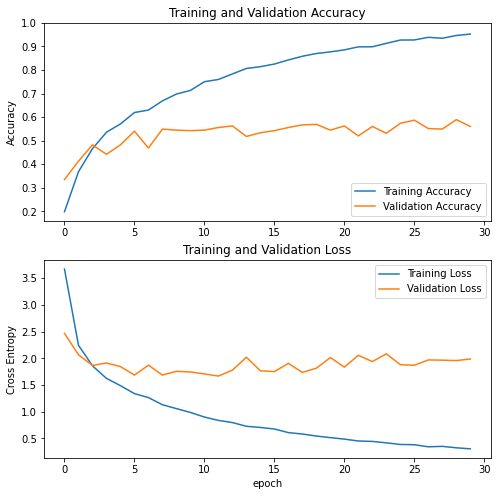

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(base_fig)
plt.show()

In [13]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)

16/16 [==============================] - 17s 1s/step - loss: 2.1049 - accuracy: 0.5510
Test accuracy: 0.5509586334228516
